# Tool Loadout

## Background

Tool loadout involves selecting only the most relevant tool definitions when managing multiple tools. Drew notes, models struggle significantly with too many tools:

- **Llama 3.1 8b fails with 46 tools** but performs better with 19 tools
- **Dynamic tool selection improved Llama 3.1 8b performance by 44%**
- Tool descriptions can overlap, causing model confusion about which tool to use

Some key insights:
- Apply RAG to tool descriptions to fetch the most relevant tools based on semantic similarity
- Performance improvements can be dramatic (3-fold improvement in tool selection accuracy)
- Essential for maintaining model performance as tool libraries grow

## Tool Loadout in Practice

Agents use tools, but can become overloaded if they are provided with too many. This is often because the tool descriptions can overlap, causing model confusion about which tool to use. One approach is to apply RAG to tool descriptions in order to fetch the most relevant tools for a task based upon semantic similarity, an idea that Drew Breunig calls "[tool loadout](https://www.dbreunig.com/2025/06/26/how-to-fix-your-context.html)." Some [recent papers](https://arxiv.org/abs/2505.03275) have shown that this improve tool selection accuracy by 3-fold.

### Tool selecting in LangGraph

For tool selection, the [LangGraph Bigtool](https://github.com/langchain-ai/langgraph-bigtool) library is a great way to apply semantic similarity search over tool descriptions for selection of the most relevant tools for a task. It leverages LangGraph's long-term memory store to allow an agent to search for and retrieve relevant tools for a given problem. Lets demonstrate `langgraph-bigtool` by equipping an agent with all functions from Python's built-in math library.

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_97870/3895214703.py:35: LangChainBetaWarning: The function `convert_positional_only_function_to_tool` is in beta. It is actively being worked on, so the API may change.
  if tool := convert_positional_only_function_to_tool(


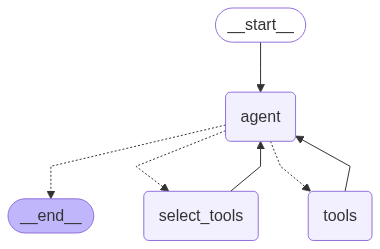

In [1]:
# TODO: Format and clean, sort imports, add docstrings 

import math
import types
import uuid

import getpass
import os
from langchain.chat_models import init_chat_model

def _set_env(var: str) -> None:
    """Set environment variable if not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [2]:
from utils import format_messages
query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": query})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use available tools to calculate arc cosine of 0.5.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll search for a tool to calculate the arc cosine of 0.5.                                                      │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_tools                                                                                    │
│    Args: {                                                                                                      │
│   "query": "arc cosine arccos inverse cosine mathematical function"                                             │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Available tools: ['acos', 'acosh']                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I found the `acos` function which calculates the arc cosine. Now I'll use it to calculate the arc      │
│ cosine of 0.5.                                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: acos                                                                                              │
│    Args: {                                                                                                      │
│   "x": 0.5                                                                                                      │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 1.0471975511965976                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The arc cosine of 0.5 is approximately **1.047 radians**.                                                       │
│                                                                                                                 │
│ This result makes sense because:                                                                                │
│ - arccos(0.5) = π/3 radians                                                                                     │
│ - π/3 ≈ 1.047 radians                                                                                           │
│ - This is equivalent to 60 degrees                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯